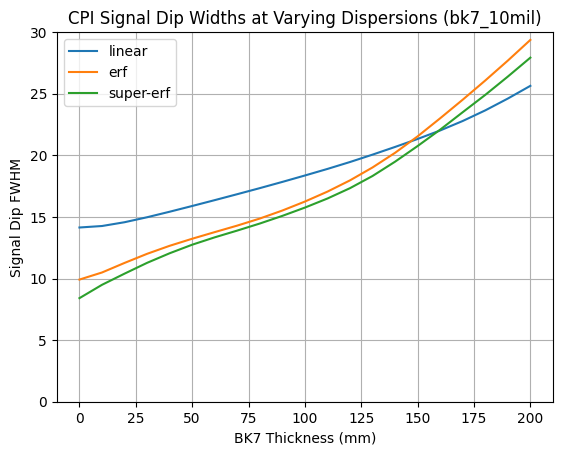

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import matplotlib.ticker as ticker
import os


linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

linear_chi2 = []
erf_chi2 = []
super_erf_chi2 = []

folder_name = "bk7_10mil"
##these are for generating the dip plots further down
Ls = [0, 10000, 50000, 100000, 150000, 200000]
titles = [f'L = {Ls[0]}', f'L = {Ls[1]}', f'L = {Ls[2]}', f'L = {Ls[3]}', f'L = {Ls[4]}', f'L = {Ls[5]}']

os.makedirs(f"results/{folder_name}/plots", exist_ok=True)

f = open(f"./results/{folder_name}/plotting_params.txt", "r")
params = f.readlines()
f.close()

dispersion_type = params[0].rstrip()
tau_range = int(params[1])
max_L = int(params[2])
L_stepsize = int(params[3])

Lvals = np.arange(0, max_L, L_stepsize)
Lvals2 = np.arange(0, 200001, L_stepsize)
taus = np.arange(-tau_range, tau_range + 0.5, 0.5)

# --- Initial guesses ---
init_guess_parabolic = [0, 0.0025, 0.00000001, 0.9, 10]
init_guess = [0, 0.0025, 0.9, 10]

def one_minus_gaussian(t, t_0, a1, a2, fwhm):
    return a1 - a2*np.exp(-4*np.log(2)*((t - t_0)**2)/fwhm**2)

def chisq(params, t, y):
    t0, a1, a2, fwhm = params
    model = one_minus_gaussian(t, t0, a1, a2, fwhm)
    return np.sum((y - model)**2)

def residuals(params, t, y):
    T0, a1, a2, sigma = params
    model = (a1 - a2 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

min_taus_lin = []
min_taus_erf = []
min_taus_superf = []

##not sure if i should normalize, then curve fit or the other way around
for L in Lvals2:
    init_guess = [0, 0.00015*L, 0.9, 10]

    lin_sig = np.loadtxt(f"./results/{folder_name}/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./results/{folder_name}/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./results/{folder_name}/super_erf/super_erf_L{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    min_taus_lin.append(taus[np.argmin(lin_sig)])
    min_taus_erf.append(taus[np.argmin(erf_sig)])
    min_taus_superf.append(taus[np.argmin(superf_sig)])

    # --- Fit the data ---
    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(residuals, init_guess, args=(taus, lin_sig), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    erf_result = least_squares(residuals, init_guess, args=(taus, erf_sig), method='lm',
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    superf_result = least_squares(residuals, init_guess, args=(taus, superf_sig), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)

    linear_chi2.append(lin_result.cost)
    erf_chi2.append(erf_result.cost)
    super_erf_chi2.append(superf_result.cost)

    linear_dip_widths.append(lin_result.x[3])
    erf_dip_widths.append(erf_result.x[3])
    super_erf_dip_widths.append(superf_result.x[3]) 


plt.plot(Lvals2, linear_dip_widths, label = "linear")
plt.plot(Lvals2, erf_dip_widths, label = "erf")
plt.plot(Lvals2, super_erf_dip_widths, label = "super-erf")
plt.xlabel(f"{dispersion_type} Thickness (mm)")
plt.ylabel("Signal Dip FWHM")
plt.legend()
plt.grid()
plt.title(f'CPI Signal Dip Widths at Varying Dispersions ({folder_name})')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
plt.ylim(0, 30);
plt.savefig(f"results/{folder_name}/plots/dip_widths.png")

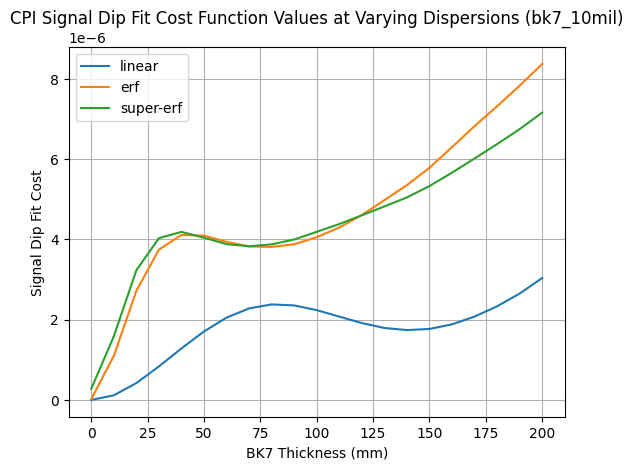

In [164]:
plt.plot(Lvals2, linear_chi2, label = "linear")
plt.plot(Lvals2, erf_chi2, label = "erf")
plt.plot(Lvals2, super_erf_chi2, label = "super-erf")
plt.xlabel(f"{dispersion_type} Thickness (mm)")
plt.ylabel("Signal Dip Fit Cost")
plt.legend()
plt.grid()
plt.title(f'CPI Signal Dip Fit Cost Function Values at Varying Dispersions ({folder_name})')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
plt.savefig(f"results/{folder_name}/plots/width_costs.png")

Chi squared makes no sense for computing error of this - of course its going to have bad values as you increase L because youre fitting a Gaussian to something with ringing. What would a better way of doing this? ideally you want the chi squared just around the curve region because thats the only part of the fit you care about

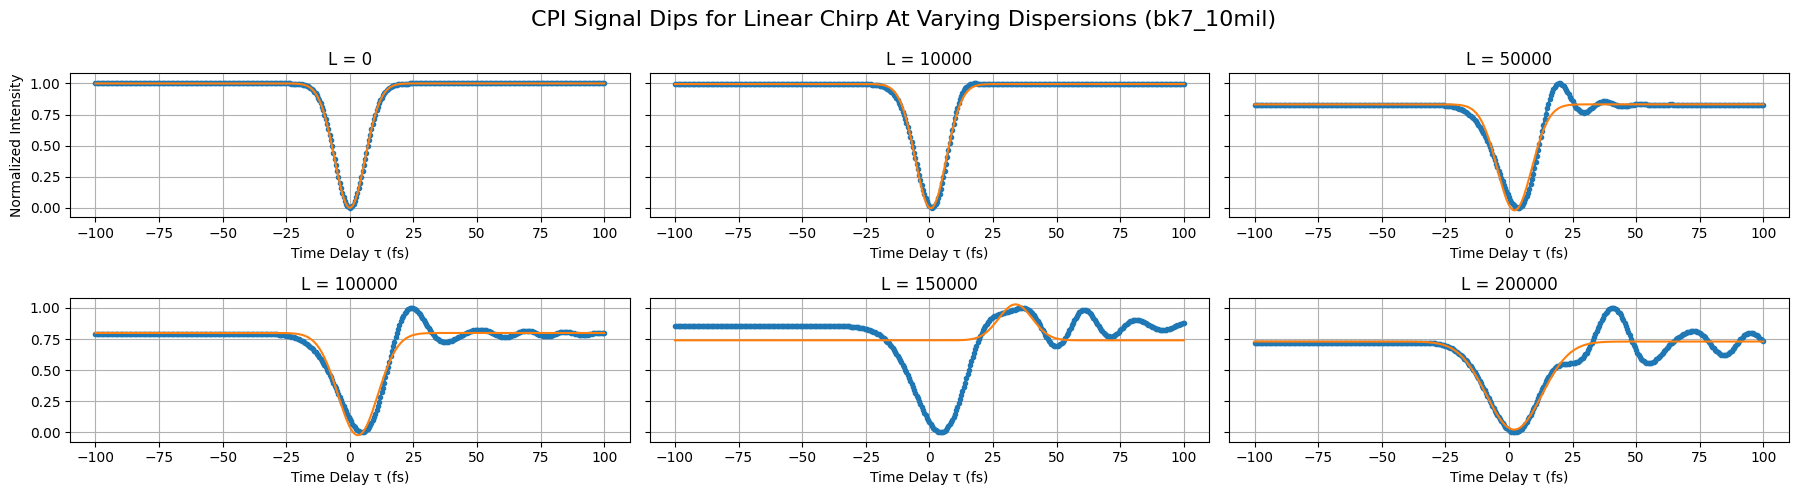

In [165]:
lin_signals = []
lin_curves = []

for L in Ls:
    
    init_guess = [0.00015*L, 0.0025, 0.9, 10]

    lin_sig = np.loadtxt(f"./results/{folder_name}/linear/linear_L{L}.txt")
    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    
    lin_signals.append(lin_norm)

    lin_result = least_squares(residuals, init_guess, args=(taus, lin_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = lin_result.x

    lin_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, lin_signals, lin_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Linear Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.savefig(f"results/{folder_name}/plots/linear_dips.png")
plt.show();

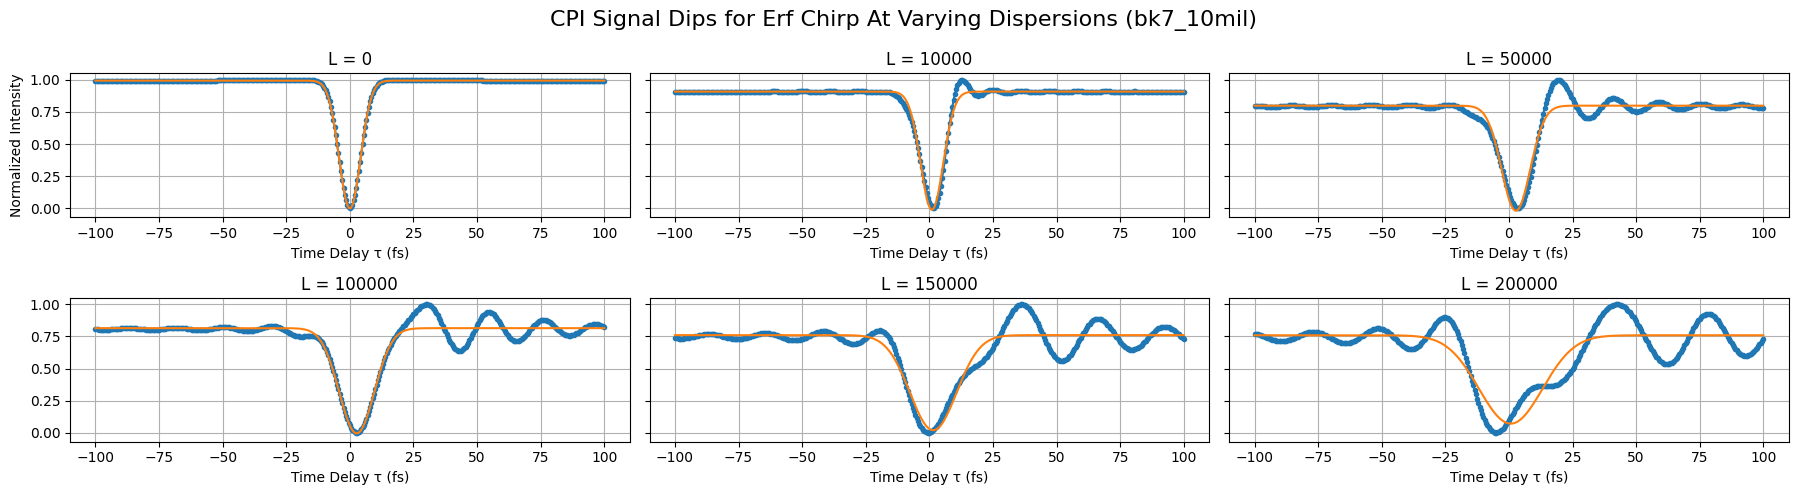

In [166]:
erf_signals = []
erf_curves = []

for L in Ls:
    
    init_guess = [0.00015*L, 0.0025, 0.9, 10]

    erf_sig = np.loadtxt(f"./results/{folder_name}/erf/erf_L{L}.txt")
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    
    erf_signals.append(erf_norm)

    erf_result = least_squares(residuals, init_guess, args=(taus, erf_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = erf_result.x

    erf_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, erf_signals, erf_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Erf Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.savefig(f"results/{folder_name}/plots/erf_dips.png")
plt.show();

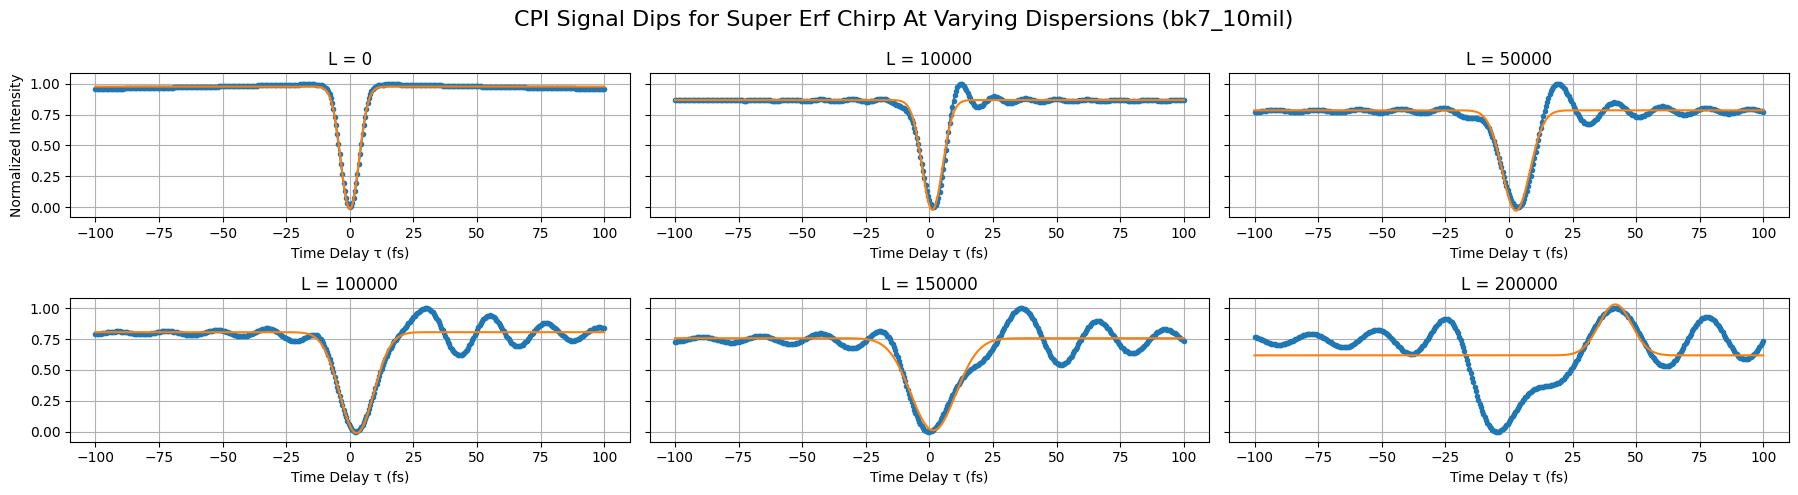

In [167]:
super_erf_signals = []
super_erf_curves = []


for L in Ls:
    
    init_guess = [0.00015*L, 0.0025, 0.9, 10]

    super_erf_sig = np.loadtxt(f"./results/{folder_name}/super_erf/super_erf_L{L}.txt")
    super_erf_norm = (super_erf_sig - np.min(super_erf_sig))/(np.max(super_erf_sig) - np.min(super_erf_sig))
    
    super_erf_signals.append(super_erf_norm)

    super_erf_result = least_squares(residuals, init_guess, args=(taus, super_erf_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = super_erf_result.x

    super_erf_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, super_erf_signals, super_erf_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Super Erf Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.savefig(f"results/{folder_name}/plots/super_erf_dips.png")
plt.show();

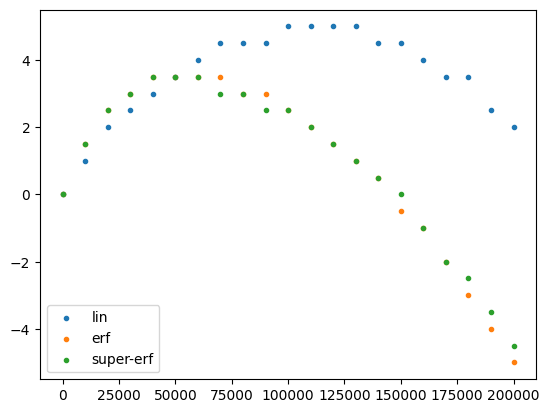

In [168]:
plt.scatter(Lvals2, min_taus_lin, marker = '.', label = "lin")
plt.scatter(Lvals2, min_taus_erf, marker = '.', label = "erf")
plt.scatter(Lvals2, min_taus_superf, marker = '.', label = "super-erf")
plt.legend()    

C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:108: RuntimeWarning: divide by zero encountered in divide
  lambdas = 2 * np.pi * c_um_per_fs / w * 1e3  # → λ in nanometers
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:93: RuntimeWarning: divide by zero encountered in divide
  lambdas = (2 * np.pi * c / w) * 1e3
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:51: RuntimeWarning: divide by zero encountered in divide
  k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) +
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:51: RuntimeWarning: invalid value encountered in divide
  k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) +
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:52: RuntimeWarning: divide by zero encountered in divide
  (b2*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c2) +
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_24312\483634780.py:52: RuntimeWarning: in

Visible wavelength count: 415269
bk7 k': %f 5.0922243297729555
epsilon min/max: 11.8653071380092 13.912441441604386
lambdas shape: (524288,)
epsilon shape: (524288,)


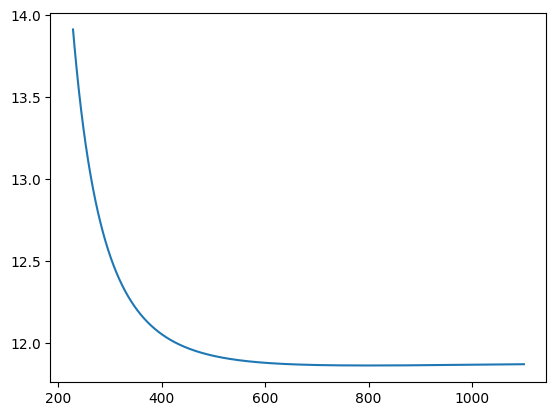

In [169]:
Npts = 2**19
ts = np.linspace(0, 400000, Npts)
dt = ts[1] - ts[0]
c = 299792458
w_0 = 2*np.pi*c*1e-15/800e-9
w = 2 * np.pi * np.arange(Npts) / (Npts * dt)

def glass_type_epsilon(w, w0, material="BK7"):
    
    c = 0.2998; #(*um/fs*)
    match material:
        case "BK7":
            b1 = 1.03961212 #(*for BK7 glass*)
            b2 = 0.231792344
            b3 = 1.01046945
            c1 = 6.00069867e-3 #(*um^2*)
            c2 = 2.00179144e-2
            c3 = 1.03560653e2
        case "Fused Silica":
            b1 =  0.6961663
            b2 = 0.4079426
            b3 = 0.8974794
            c1 = 0.00467914826
            c2 = 0.0135120631
            c3 = 97.9340025
        case "Sapphire":
            b1 = 1.43134930
            b2 = 0.650547130
            b3 = 5.34140210
            c1 = 0.00527992610
            c2 = 0.0142382647
            c3 = 325.017834
        case "CaF2":
            b1 = 0.5675888
            b2 = 0.4710914
            b3 = 3.8484723
            c1 = 0.00252642999
            c2 = 0.0100783328
            c3 = 1200.555973
        case "SF10":
            b1 = 1.62153902
            b2 = 0.256287842
            b3 = 1.64447552
            c1 = 0.0122241457
            c2 = 0.0595736775
            c3 = 103.560653
        case _:
            print("Error! invalid water type")
            return 0

    k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) + 
                     (b2*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c2) + 
                     (b3*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c3)))/c
    
    k_deriv = np.sqrt(1 +((4*b1*(c**2)*(np.pi**2))/(-c1*(w0**2) + (2*c*np.pi)**2)) + 
                      ((4*b2*(c**2)*(np.pi**2))/(-c2*(w0**2) + (2*c*np.pi)**2)) + 
                      ((4*b3*(c**2)*(np.pi**2))/(-c3*(w0**2) + (2*c*np.pi)**2)))/c + w0*(
                          (32*b1*(c*np.pi)**4)/((w0**5)*((-c1 + ((2*c*np.pi)**2)/(w0**2))**2)) +
                          (32*b2*(c*np.pi)**4)/((w0**5)*((-c2 + ((2*c*np.pi)**2)/(w0**2))**2)) +
                          (32*b3*(c*np.pi)**4)/((w0**5)*((-c3 + ((2*c*np.pi)**2)/(w0**2))**2)) -
                          (8*b1*(c*np.pi)**2)/((w0**3)*(-c1 + ((2*c*np.pi)**2)/(w0**2))) -
                          (8*b2*(c*np.pi)**2)/((w0**3)*(-c2 + ((2*c*np.pi)**2)/(w0**2))) -
                          (8*b3*(c*np.pi)**2)/((w0**3)*(-c3 + ((2*c*np.pi)**2)/(w0**2))))/(
                              2*c*np.sqrt(1 + (b1*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c1) + 
                                          (b2*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c2) + 
                                          (b3*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c3)))

    n = (np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) + 
                     (b2*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c2) + 
                     (b3*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c3)))

    print("bk7 k': %f", k_deriv)
    return k_w - k_deriv*(w - w0)


#from https://opg.optica.org/ao/fulltext.cfm?uri=ao-36-16-3785
#T must be between 0 and 30
#S is salinity, in parts per thousand (35 is seawater)
def water_epsilon(w, w0, T=20, S=0):
    c = 0.2998; #(*um/fs*)
    
    n0 = 1.31405
    n1 = 1.779e-4
    n2 = -1.05e-6
    n3 = 1.6e-8
    n4 = -2.02e-6
    n5 = 15.868
    n6 = 0.01155
    n7 = -0.00423
    n8 = -4382
    n9 = 1.1455e6

    lambdas = (2 * np.pi * c / w) * 1e3

    lambda_0 = (2*1000*np.pi*c/w0)

    k_w = w*(n0 + (n1 + n2*T + n3*T**2)*S + n4*T**2 +(n5 + n6*S + n7*T)/lambdas + 
             n8/lambdas**2 + n9/lambdas**3)/c
    k_deriv = ((n1 + n2*T + n3*T**2)*S + n4*T**2 - n8/lambda_0**2 - 2*n9/lambda_0**3)/c


    n_lambda = (n0 + (n1 + n2*T + n3*T**2)*S + n4*T**2 +(n5 + n6*S + n7*T)/lambdas + 
             n8/lambdas**2 + n9/lambdas**3)
    
    return k_w - k_deriv*(w - w0)

c_um_per_fs = 0.2998
lambdas = 2 * np.pi * c_um_per_fs / w * 1e3  # → λ in nanometers

mask = (lambdas >= 200) & (lambdas <= 1100)
print("Visible wavelength count:", np.sum(mask))

water_eps = water_epsilon(w, w_0)
bk7_eps = glass_type_epsilon(w, w_0)
epsilon = np.nan_to_num(bk7_eps, nan=1e-6, posinf=1e-6, neginf=1e-6)
print("epsilon min/max:", np.min(epsilon[mask]), np.max(epsilon[mask]))

print("lambdas shape:", lambdas.shape)
print("epsilon shape:", epsilon.shape)


plt.plot(lambdas[mask], epsilon[mask])

In [170]:
import sys
print(sys.executable)

c:\Users\Berjoska\AppData\Local\Programs\Python\Python313\python.exe


In [171]:
'''
#attempting with jax now!
import jax
import jax.numpy as jnp
from jax import jit, jacrev
import numpy as np
from scipy.optimize import least_squares
from jax import config 
config.update("jax_enable_x64", True)

def model(params, t):
    T0, a1, a2, a3, sigma = params
    return (a1 - a2 * (t - T0)**2) * (1 - a3 * jnp.exp(-4 * jnp.log(2) * (t - T0)**2 / sigma**2))

def residuals(params, t, y):
    return model(params, t) - y

jacobian_fn = jit(jacrev(residuals))
x0 = jnp.array([0, 0.0025, 1e-8, 0.9, 10.0])

linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

for L in Lvals:
    lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")

    lin_sig = np.loadtxt(f"./transition docs copy/Mar7_results/lin_dips_mar7/dip_{L}.txt")
    erf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/erf_dips_mar7/dip_{L}.txt")
    superf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/super_dips_mar7/dip_{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    #lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    #superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, lin_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, lin_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    erf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, erf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, erf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    superf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, superf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, superf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)

    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    
    linear_dip_widths.append(lin_result.x[4])
    erf_dip_widths.append(erf_result.x[4])
    super_erf_dip_widths.append(superf_result.x[4]) 

print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])

np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Lvals, linear_dip_widths, label = "linear")
plt.plot(Lvals, erf_dip_widths, label = "erf")
plt.plot(Lvals, super_erf_dip_widths, label = "super-erf")
plt.ylim(0, 30)
'''

'\n#attempting with jax now!\nimport jax\nimport jax.numpy as jnp\nfrom jax import jit, jacrev\nimport numpy as np\nfrom scipy.optimize import least_squares\nfrom jax import config \nconfig.update("jax_enable_x64", True)\n\ndef model(params, t):\n    T0, a1, a2, a3, sigma = params\n    return (a1 - a2 * (t - T0)**2) * (1 - a3 * jnp.exp(-4 * jnp.log(2) * (t - T0)**2 / sigma**2))\n\ndef residuals(params, t, y):\n    return model(params, t) - y\n\njacobian_fn = jit(jacrev(residuals))\nx0 = jnp.array([0, 0.0025, 1e-8, 0.9, 10.0])\n\nlinear_dip_widths = []\nerf_dip_widths = []\nsuper_erf_dip_widths = []\n\nfor L in Lvals:\n    lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")\n    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")\n    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")\n\n    lin_sig = np.loadtxt(f"./transition docs copy/Mar7_results/lin_dips_mar7/dip_{L}.txt")\n    erf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/erf_dips_m